### This is the Bilateral Grid version of Bilateral Filter.

*I hope you could tell the difference between the two!*

![Bilateral Grid](bilateral_grid.png "Bilateral Grid")

Please make sure you have installed：
- numpy;
- scipy;

In [1]:
import numpy as np
from scipy.signal import gaussian

def bilateral_filter_grid(image, sigma_spatial, sigma_range):
    """
    使用双边网格实现的快速双边滤波器。

    Args:
        image (np.ndarray): 输入的灰度图像，像素值范围应在 [0, 1] 之间。
        sigma_spatial (float): 空间高斯函数的标准差。
        sigma_range (float): 强度范围高斯函数的标准差。

    Returns:
        np.ndarray: 滤波后的图像。
    """
    # 获取图像尺寸和强度范围
    height, width = image.shape
    im_min, im_max = np.min(image), np.max(image)
    value_range = im_max - im_min

    # 1. 计算网格尺寸
    # 空间维度下采样，减小计算量
    s_s = int(sigma_spatial)
    # 强度维度下采样
    s_r = int(sigma_range * 255 / (value_range if value_range > 0 else 1)) # 假设原始范围为[0, 255]

    grid_width = width // s_s
    grid_height = height // s_s
    grid_depth = int(value_range * 255) // s_r

    # 2. 创建双边网格 (Bilateral Grid)
    # 使用(w, v)的齐次坐标来简化计算，w是权重，v是加权后的值
    grid = np.zeros((grid_height, grid_width, grid_depth, 2), dtype=np.float32)

    # 3. "Splat" - 将图像数据填充到网格中
    # 将每个像素的值和权重（这里是1）分布到其在网格中对应的位置
    for y in range(height):
        for x in range(width):
            # 计算在网格中的坐标
            grid_y = int(y / s_s + 0.5)
            grid_x = int(x / s_s + 0.5)
            # 将像素强度归一化并计算网格深度坐标
            grid_z = int(((image[y, x] - im_min) / value_range) * (grid_depth - 1) + 0.5)

            # 边界检查
            gy, gx, gz = min(grid_y, grid_height-1), min(grid_x, grid_width-1), min(grid_z, grid_depth-1)

            # 累加值和权重
            grid[gy, gx, gz, 0] += image[y, x] # 值
            grid[gy, gx, gz, 1] += 1           # 权重 (w)

    # 4. "Blur" - 对网格进行三维高斯模糊
    # 创建三维高斯核
    # 空间核 (x, y)
    kernel_spatial_size = int(2 * sigma_spatial / s_s * 2 + 1)
    kernel_spatial = gaussian(kernel_spatial_size, sigma_spatial / s_s).reshape(-1, 1)
    kernel_spatial_2d = np.outer(kernel_spatial, kernel_spatial)

    # 强度核 (z)
    kernel_range_size = int(2 * sigma_range / s_r * 2 + 1)
    kernel_range = gaussian(kernel_range_size, sigma_range / s_r)

    # 使用scipy的convolve函数进行模糊，但为了简化，我们这里手动实现可分离的卷积
    # Scipy的ndimage.gaussian_filter会更高效，但这里为了清晰地展示步骤
    blurred_grid = np.zeros_like(grid)
    
    # 模糊 x-y 平面
    for z in range(grid_depth):
        for c in range(2): # 对值和权重都进行模糊
            # 使用简单的2D卷积代替
            from scipy.ndimage import convolve
            blurred_grid[:, :, z, c] = convolve(grid[:, :, z, c], kernel_spatial_2d, mode='constant')

    # 模糊 z 维度
    # 为了简化，我们沿着z轴进行一维卷积
    # (这可以通过交换轴和使用2D卷积实现，或直接循环)
    final_blurred_grid = np.zeros_like(blurred_grid)
    for y in range(grid_height):
        for x in range(grid_width):
            for c in range(2):
                 final_blurred_grid[y, x, :, c] = np.convolve(blurred_grid[y, x, :, c], kernel_range, mode='same')


    # 5. "Slice" - 从模糊后的网格中插值得到结果
    # 通过三线性插值从模糊后的网格中取回数据
    output = np.zeros_like(image, dtype=np.float32)
    for y in range(height):
        for x in range(width):
            # 计算浮点坐标
            fy = y / s_s
            fx = x / s_s
            fz = ((image[y, x] - im_min) / value_range) * (grid_depth - 1)

            # 获取整数坐标用于插值
            iy = int(fy)
            ix = int(fx)
            iz = int(fz)
            
            # 边界检查
            if iy >= grid_height - 1 or ix >= grid_width - 1 or iz >= grid_depth - 1:
                gy, gx, gz = min(iy, grid_height - 1), min(ix, grid_width - 1), min(iz, grid_depth - 1)
                val, weight = final_blurred_grid[gy, gx, gz]
                if weight > 0:
                    output[y, x] = val / weight
                else:
                    output[y, x] = image[y, x] # 如果权重为0，则保留原值
                continue

            # 三线性插值
            wx = fx - ix
            wy = fy - iy
            wz = fz -iz

            # 插值计算
            v000, w000 = final_blurred_grid[iy, ix, iz]
            v001, w001 = final_blurred_grid[iy, ix, iz + 1]
            v010, w010 = final_blurred_grid[iy, ix + 1, iz]
            v011, w011 = final_blurred_grid[iy, ix + 1, iz + 1]
            v100, w100 = final_blurred_grid[iy + 1, ix, iz]
            v101, w101 = final_blurred_grid[iy + 1, ix, iz + 1]
            v110, w110 = final_blurred_grid[iy + 1, ix + 1, iz]
            v111, w111 = final_blurred_grid[iy + 1, ix + 1, iz + 1]
            
            # 插值权重
            total_w = (1 - wy) * ((1 - wx) * w000 + wx * w010) + wy * ((1 - wx) * w100 + wx * w110) # 简化的插值
            
            # 插值值
            total_v = 0
            # 完整的三线性插值
            c00 = v000 * (1 - wx) + v010 * wx
            c01 = v001 * (1 - wx) + v011 * wx
            c10 = v100 * (1 - wx) + v110 * wx
            c11 = v101 * (1 - wx) + v111 * wx
            c0 = c00 * (1 - wy) + c10 * wy
            c1 = c01 * (1 - wy) + c11 * wy
            interpolated_v = c0 * (1 - wz) + c1 * wz

            # 插值权重
            wc00 = w000 * (1 - wx) + w010 * wx
            wc01 = w001 * (1 - wx) + w011 * wx
            wc10 = w100 * (1 - wx) + w110 * wx
            wc11 = w101 * (1 - wx) + w111 * wx
            wc0 = wc00 * (1 - wy) + wc10 * wy
            wc1 = wc01 * (1 - wy) + wc11 * wy
            interpolated_w = wc0 * (1 - wz) + wc1 * wz

            if interpolated_w > 0:
                output[y, x] = interpolated_v / interpolated_w
            else:
                output[y, x] = image[y, x] # 保留原值以防万一

    return output

开始使用双边网格进行滤波...
滤波完成！


/var/folders/8l/myqnfw3j7x78564pzn6xzw3w0000gn/T/ipykernel_63446/2069132778.py:41: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from current font.
  plt.tight_layout()
/var/folders/8l/myqnfw3j7x78564pzn6xzw3w0000gn/T/ipykernel_63446/2069132778.py:41: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from current font.
  plt.tight_layout()
/var/folders/8l/myqnfw3j7x78564pzn6xzw3w0000gn/T/ipykernel_63446/2069132778.py:41: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from current font.
  plt.tight_layout()
/var/folders/8l/myqnfw3j7x78564pzn6xzw3w0000gn/T/ipykernel_63446/2069132778.py:41: UserWarning: Glyph 20687 (\N{CJK UNIFIED IDEOGRAPH-50CF}) missing from current font.
  plt.tight_layout()
/var/folders/8l/myqnfw3j7x78564pzn6xzw3w0000gn/T/ipykernel_63446/2069132778.py:41: UserWarning: Glyph 24102 (\N{CJK UNIFIED IDEOGRAPH-5E26}) missing from current font.
  plt.tight_layout()
/var/folders/8l/myqnfw3j7x78564pzn6xzw3w0000gn/T/ipyker

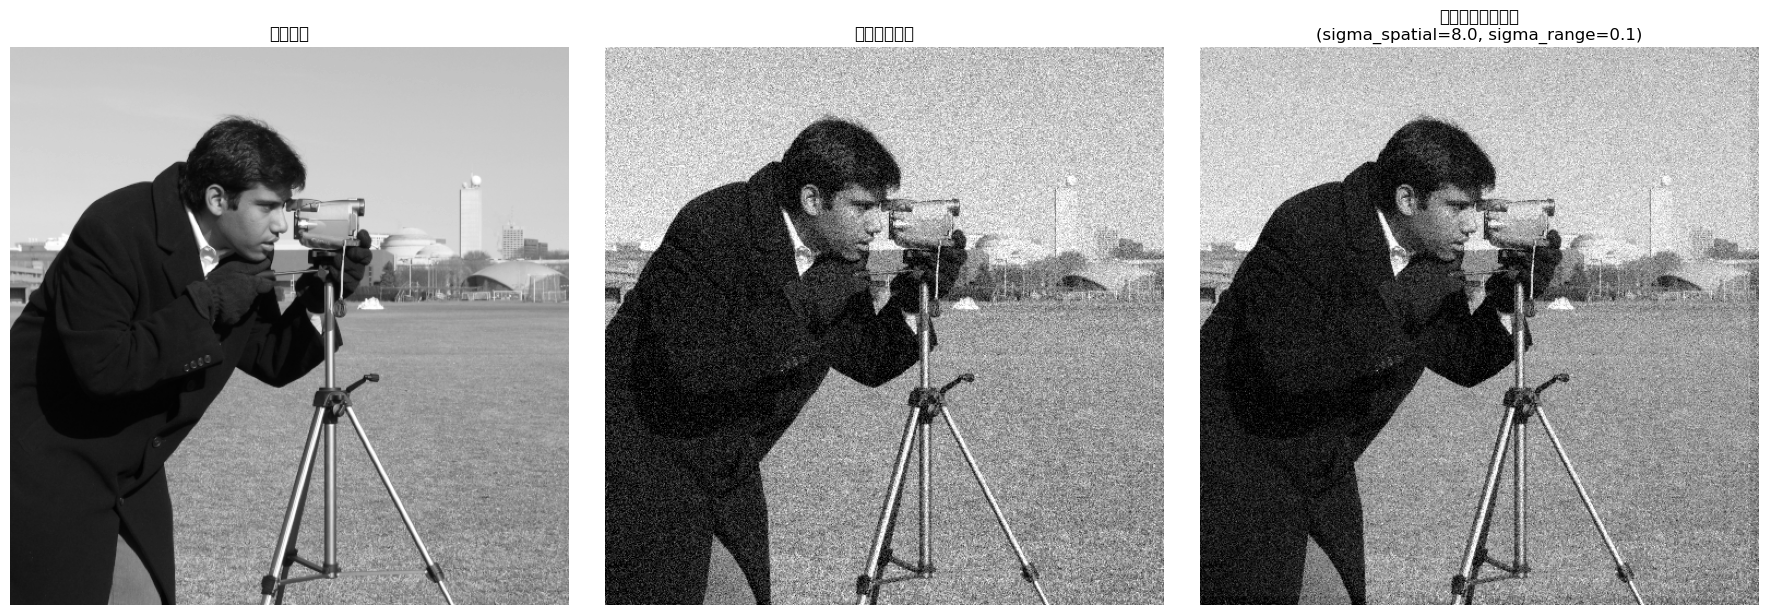

In [2]:
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import random_noise
from skimage.color import rgb2gray
from skimage import img_as_float

if __name__ == '__main__':
    # 1. 加载一个示例图像并转换为灰度图
    # image = rgb2gray(data.astronaut())
    image = img_as_float(data.camera())
    
    # 2. 添加一些高斯噪声
    noisy_image = random_noise(image, mode='gaussian', var=0.01)

    # 3. 设置参数并应用滤波器
    # sigma_spatial: 空间距离的标准差，值越大，模糊范围越广（保边效果减弱）
    # sigma_range:   像素强度差的标准差，值越大，对强度差异越不敏感（去噪能力增强但可能模糊边缘）
    sigma_spatial = 8.0
    sigma_range = 0.1

    print("开始使用双边网格进行滤波...")
    filtered_image = bilateral_filter_grid(noisy_image, sigma_spatial, sigma_range)
    print("滤波完成！")

    # 4. 显示结果
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    ax = axes.ravel()

    ax[0].imshow(image, cmap='gray')
    ax[0].set_title("原始图像")
    ax[0].axis('off')

    ax[1].imshow(noisy_image, cmap='gray')
    ax[1].set_title("带噪声的图像")
    ax[1].axis('off')

    ax[2].imshow(filtered_image, cmap='gray')
    ax[2].set_title(f"双边网格滤波结果\n(sigma_spatial={sigma_spatial}, sigma_range={sigma_range})")
    ax[2].axis('off')

    plt.tight_layout()
    plt.show()

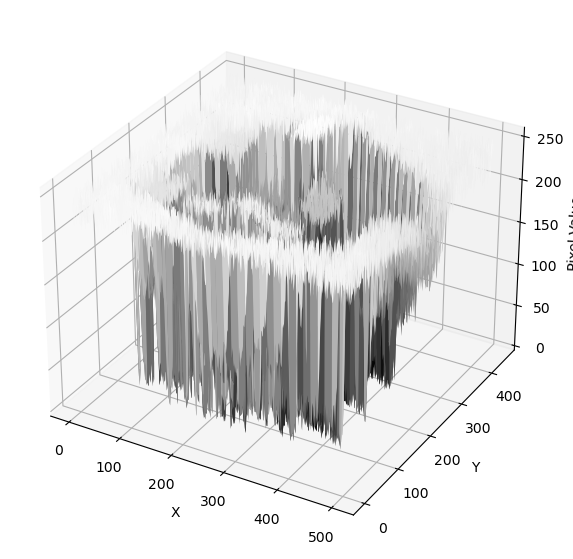

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from PIL import Image

# Load image (replace 'your_image.png' with your image path)
img = Image.open('noisy_input.png').convert('L')  # Ensure grayscale
img_array = np.array(img)

# Create X, Y grid
x = np.arange(img_array.shape[1])
y = np.arange(img_array.shape[0])
X, Y = np.meshgrid(x, y)

# Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, img_array, cmap='gray')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Pixel Value')
plt.show()